# SLUM products example 

In [1]:
import folium
import rasterio
import numpy as np

In [2]:
DATA_DIR = "/work/scratch/tanguyy/public/TU_SLUM/"
OUT_DIR = "/work/scratch/gratadb/SRC/" ### /!\ Change directory

# Basis image path
RGB_path = DATA_DIR + "image_PHR/xt_PHR_255_RGB.tif"
RGB_path_wgs84 = OUT_DIR + "xt_PHR_255_RGB_wgs84.tif"

## Basis image visualisation

The following function reproject a .tiff file in an other CRS 

In [3]:
from rasterio.warp import calculate_default_transform, reproject, Resampling


def reproject_raster(input_file, output_file, output_crs):

    with rasterio.open(input_file) as src:
        transform, width, height = calculate_default_transform(
            src.crs, output_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update(
            {
                "crs": output_crs,
                "transform": transform,
                "width": width,
                "height": height,
            }
        )

        with rasterio.open(output_file, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    output_crs=output_crs,
                    resampling=Resampling.nearest,
                )

To plot the RGB image with folium, it need to be in EPSG:4326 projection.

In [4]:
RGB_im = rasterio.open(RGB_path)
print(RGB_im.crs)
reproject_raster(RGB_path, RGB_path_wgs84, "EPSG:4326")
RGB_im = rasterio.open(RGB_path_wgs84)
print(RGB_im.crs)

EPSG:32631
EPSG:4326


Beside the folium package only read array with shapes MxN, MxNx3 or MxNx4. We need to transpose our array axis.

In [5]:
print(RGB_im.read().shape)
transpo_im = np.transpose(RGB_im.read(), (1, 2, 0))
print(transpo_im.shape)

(3, 584, 748)
(584, 748, 3)


Now, the image can be plot on a map.


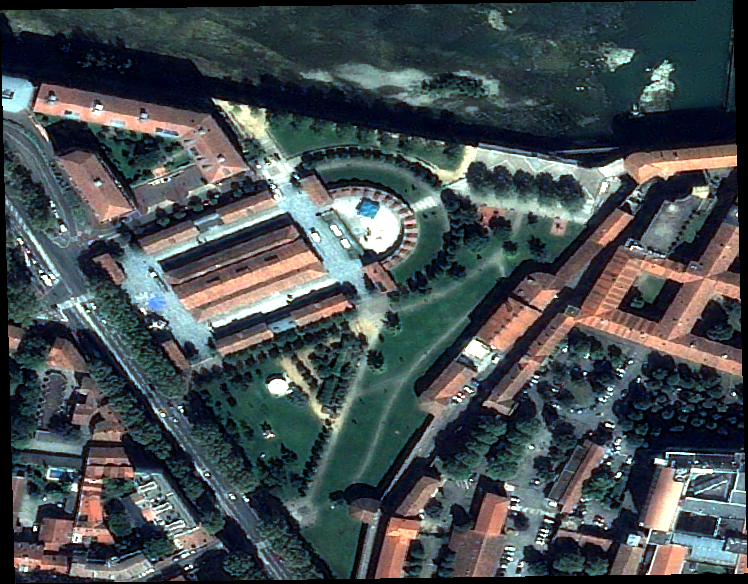

In [6]:
x1, y1, x2, y2 = RGB_im.bounds  # Get coordinates of image bounds
lon, lat = RGB_im.lnglat()  # Get longitude and latitude

m = folium.Map(location=[lat, lon], zoom_start=20)
folium.raster_layers.ImageOverlay(
    image=transpo_im,
    bounds=[[y1, x1], [y2, x2]],
    overlay=True,
    opacity=0.9,
    name="base image",
).add_to(m)

m

## See all the masks


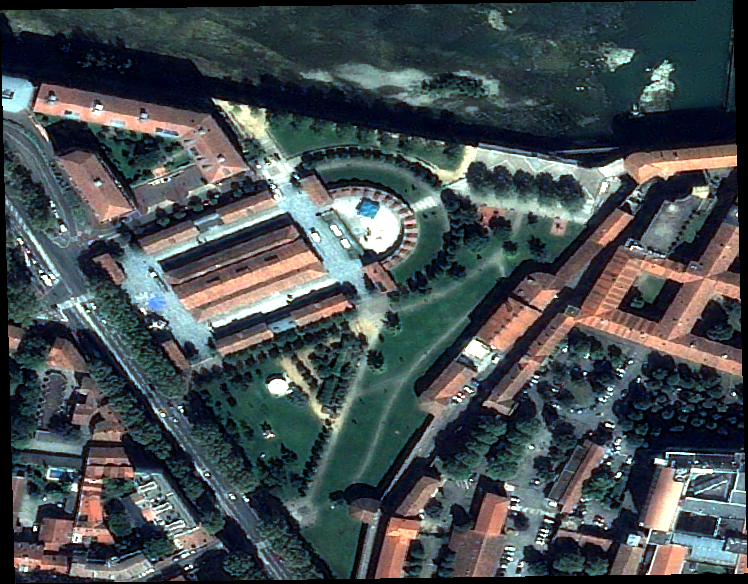
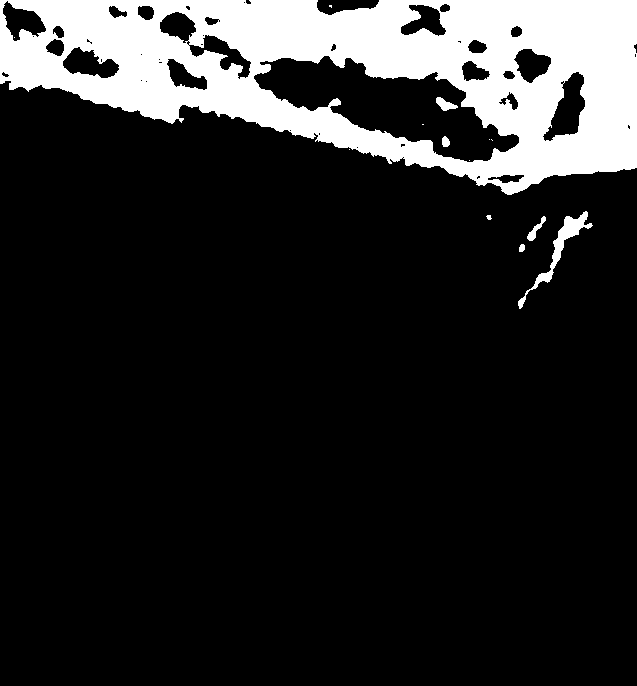
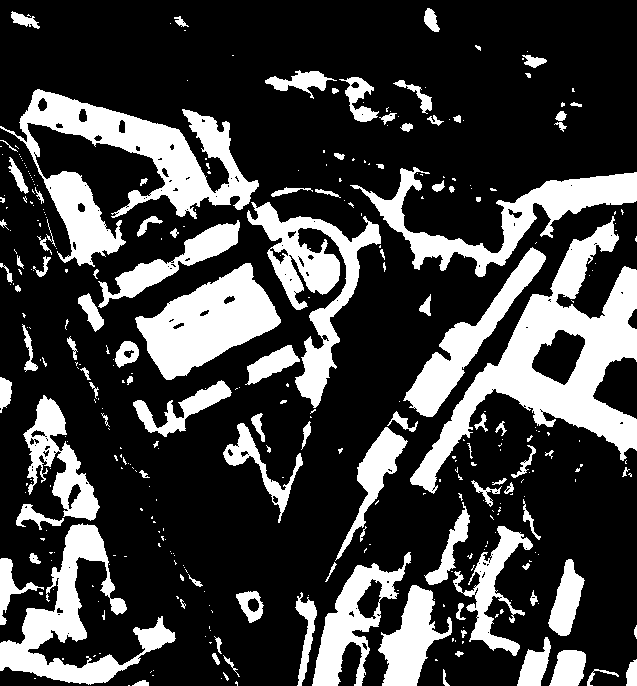
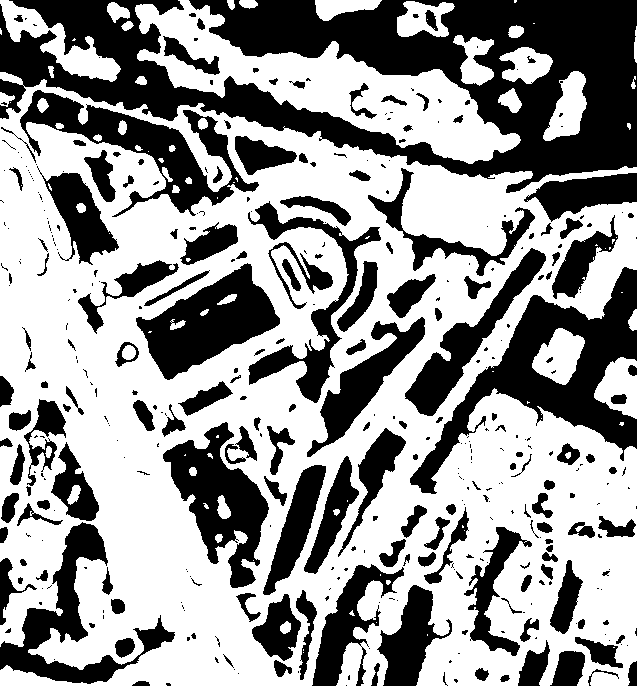
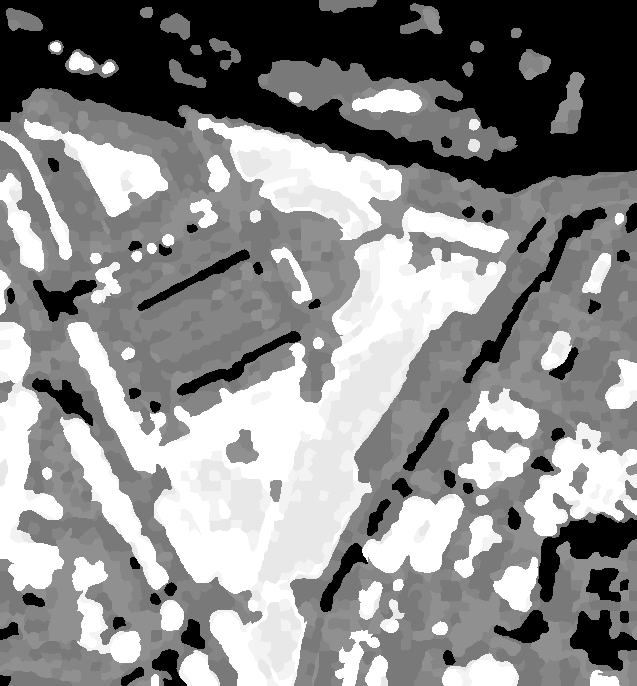
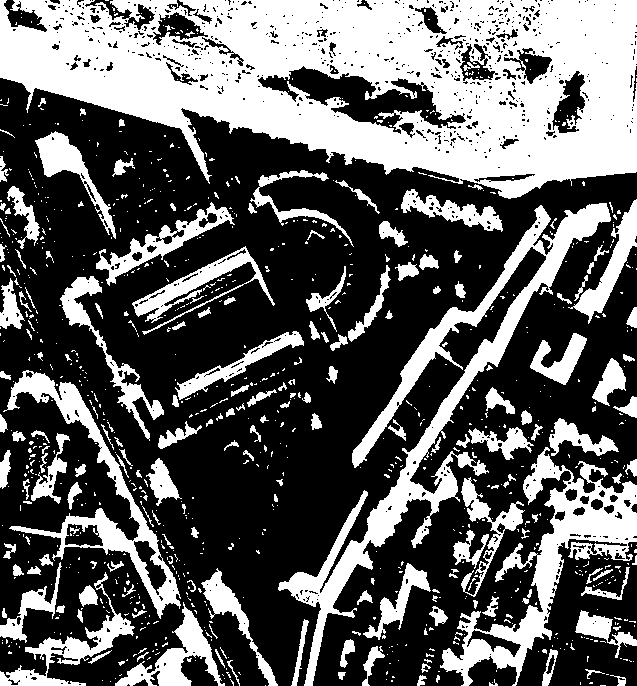

In [7]:
#Basis image
x1, y1, x2, y2 = RGB_im.bounds  # Get coordinates of image bounds
lon, lat = RGB_im.lnglat()  # Get longitude and latitude

m = folium.Map(location=[lat, lon], zoom_start=20)
folium.raster_layers.ImageOverlay(   # create a layer from the "image"
    image=transpo_im,
    bounds=[[y1, x1], [y2, x2]],
    overlay=True,
    opacity=0.9,
    name="base image",
).add_to(m)                         # add the layer to the map named "m"

#Plot watermask
watermask = rasterio.open(DATA_DIR + "watermask/watermask.tif")

folium.raster_layers.ImageOverlay(
    image=watermask.read()[0],
    bounds=[[y1, x1], [y2, x2]],
    opacity=0.5,
    name="watermask",
).add_to(m)

#Plot buildings mask
buildingmask = rasterio.open(DATA_DIR + "urban/classif_building.tif")

folium.raster_layers.ImageOverlay(
    image=buildingmask.read()[0],
    bounds=[[y1, x1], [y2, x2]],
    opacity=0.5,
    name="buildings",
).add_to(m)

#Pot roads mask
roadmask = rasterio.open(DATA_DIR + "urban/classif_road.tif")

folium.raster_layers.ImageOverlay(
    image=roadmask.read()[0],
    bounds=[[y1, x1], [y2, x2]],
    opacity=0.5,
    name="roads",
).add_to(m)

#Plot vegetation mask
vegemask = rasterio.open(DATA_DIR + "vegetation/mask_SLIC.tif")

folium.raster_layers.ImageOverlay(
    image=vegemask.read()[0],
    bounds=[[y1, x1], [y2, x2]],
    opacity=0.5,
    name="vegetation",
).add_to(m)

#Plot shadows mask
shadowmask = rasterio.open(DATA_DIR + "shadows/shadowmask.tif")

folium.raster_layers.ImageOverlay(
    image=shadowmask.read()[0],
    bounds=[[y1, x1], [y2, x2]],
    opacity=0.5,
    name="shadow",
).add_to(m)

folium.LayerControl().add_to(m)   # Add a controler in the top right corner 

m   #print the map "m"

# Compare masks

<AxesSubplot:title={'center':'Shadow'}>

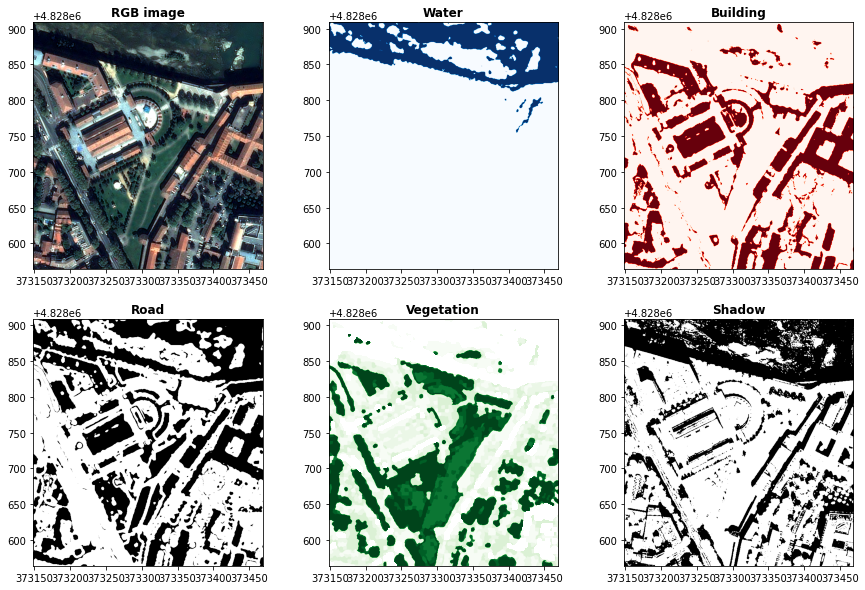

In [8]:
from rasterio.plot import show
import matplotlib.pyplot as plt

fig,axs =plt.subplots(2,3,figsize=(15,10))
im_RGB = rasterio.open(RGB_path)

#Plot all masks
show(im_RGB, ax=axs[0, 0],title="RGB image")
show(watermask, ax=axs[0, 1],title="Water",cmap="Blues")
show(buildingmask, ax=axs[0, 2],title="Building",cmap="Reds")
show(roadmask, ax=axs[1, 0],title="Road",cmap="Greys_r")
show(vegemask, ax=axs[1, 1],title="Vegetation",cmap="Greens")
show(shadowmask, ax=axs[1, 2],title="Shadow",cmap="Greys")


## Visualisation du mask final

Let's beging by create your colormap for the different classes on the mask. To know the class labels, a rasterio *tag* has been added at the creation of the mask has follow : 

In [22]:
stackmask = rasterio.open(OUT_DIR + "/stack_no_MNH_regul.tif",'r+') # Need to be open with 'r+' mode or 'w+' mode
stackmask.update_tags(class_label=['undef','low_vegetation','high_vegetation', 'water', 'buildings', 'undef_water_urban', 'bare_ground', 'undef_urban_bare_ground', 'water_pred', 'shadow', 'roads']) 
print(stackmask.tags())

{'AREA_OR_POINT': 'Area', 'class_label': "['undef', 'low_vegetation', 'high_vegetation', 'water', 'buildings', 'undef_water_urban', 'bare_ground', 'undef_urban_bare_ground', 'water_pred', 'shadow', 'roads']"}


Now we can recover this tag to build our colormap with coherent colors.

In [23]:
from matplotlib.colors import ListedColormap                
cmap = ListedColormap(['white','lime', 'darkgreen' ,'cyan','orange','blue','brown','chocolate','blueviolet','black','silver'])

Then plot, on a folium map, the basis image and the final mask.


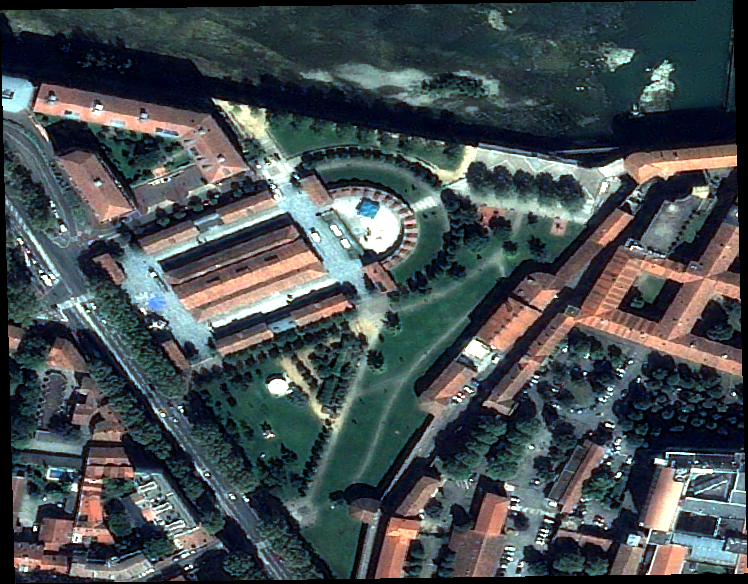
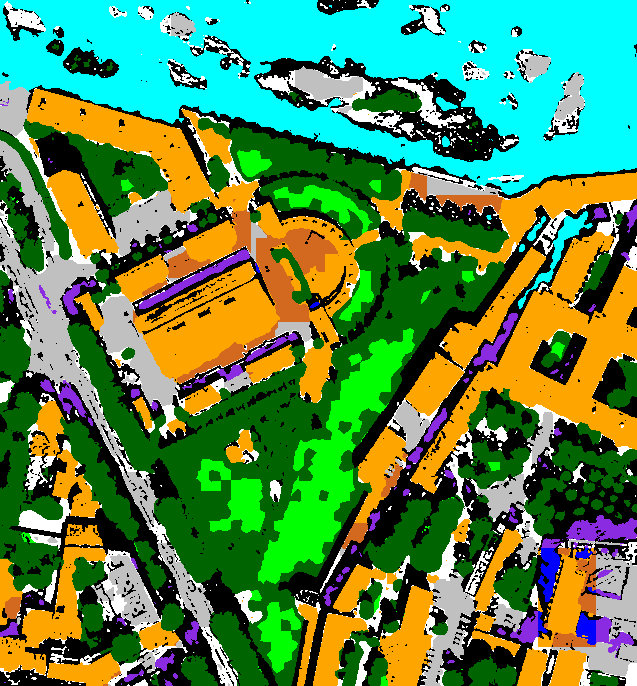

In [30]:
#Basis image
x1, y1, x2, y2 = RGB_im.bounds  # Get coordinates of image bounds
lon, lat = RGB_im.lnglat()  # Get longitude and latitude

m = folium.Map(location=[lat, lon], zoom_start=20)
folium.raster_layers.ImageOverlay(
    image=transpo_im,
    bounds=[[y1, x1], [y2, x2]],
    overlay=True,
    opacity=1,
    name="base image",
).add_to(m)

# Add the final mask
stackmask = rasterio.open(DATA_DIR + "stack/stack_no_MNH_regul.tif")

folium.raster_layers.ImageOverlay(
    image=stackmask.read()[0],
    bounds=[[y1, x1], [y2, x2]],
    opacity=1,
    name="final mask",
    colormap=cmap
).add_to(m)

folium.LayerControl().add_to(m)

m